In [1]:
using Rocket, ReactiveMP, GraphPPL
using Random, Distributions
using BenchmarkTools, Plots

In [2]:
# All benchmarks have been peroformed on a regular MacbookPro 2018 with Julia 1.6.3
import Pkg; Pkg.status(); versioninfo() 

     Project ReactiveMPBenchmarkCI v0.1.0
      Status `~/.julia/dev/ReactiveMP/benchmark/Project.toml`
  [20533458] BenchmarkCI v0.1.7
  [6e4b80f9] BenchmarkTools v0.5.0
  [13f3f980] CairoMakie v0.6.6
  [31c24e10] Distributions v0.25.31
  [b3f8163a] GraphPPL v1.0.5
  [6fafb56a] Memoization v0.1.13
  [32113eaa] PkgBenchmark v0.2.10
  [91a5bcdd] Plots v1.23.6
  [a194aa59] ReactiveMP v1.1.0 `..`
  [37e2e3b7] ReverseDiff v1.10.0
  [df971d30] Rocket v1.3.18
  [2a0f44e3] Base64
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


## State Estimation in a Linear Multivariate Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.png" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

For smoothing (forward-backward) estimation in ReactiveMP.jl, it is possible to build a full graph of the model.

In [3]:
# We create model using GraphPPL.jl package interface with @model macro
# For simplicity of the example we consider all matrices to be known and constant
@model function linear_gaussian_ssm_smoothing(n, A, B, P, Q)
     
    x = randomvar(n) # Create a sequence of random variables
    y = datavar(Vector{Float64}, n) # Create a sequence of observed multivariate data points
    
    cA = constvar(A)
    cB = constvar(B)
    cP = constvar(P)
    cQ = constvar(Q)
    
    # Set a prior distribution for x[1]
    x[1] ~ MvGaussianMeanCovariance([ 0.0, 0.0 ], [ 100.0 0.0; 0.0 100.0 ]) 
    y[1] ~ MvGaussianMeanCovariance(B * x[1], Q)
    
    for t in 2:n
        x[t] ~ MvGaussianMeanCovariance(A * x[t - 1], P)
        y[t] ~ MvGaussianMeanCovariance(B * x[t], Q)    
    end
    
    return x, y
end

# It is also possible to create a single time step of the graph
# for filtering algorithm
@model function linear_gaussian_ssm_filtering(A, B, P, Q)
    
    # Priors for the previous x_t-1 step
    x_min_t_mean = datavar(Vector{Float64})
    x_min_t_cov  = datavar(Matrix{Float64})
    
    x_min_t ~ MvGaussianMeanCovariance(x_min_t_mean, x_min_t_cov)
    x_t     ~ MvGaussianMeanCovariance(A * x_min_t, P)
    
    y_t = datavar(Vector{Float64})
    y_t ~ MvGaussianMeanCovariance(B * x_t, Q)
    
    return x_min_t_mean, x_min_t_cov, x_t, y_t
end

linear_gaussian_ssm_filtering (generic function with 1 method)

In [4]:
function generate_data(n, A, B, P, Q; seed = 1234)
    Random.seed!(seed)

    x_prev = zeros(2)
    x      = Vector{Vector{Float64}}(undef, n)
    y      = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i]   = rand(MvNormal(A * x_prev, P))
        y[i]   = rand(MvNormal(B * x[i], Q))
        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [5]:
n = 1000
θ = π / 30
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 0.1 0.0; 0.0 0.1 ]
Q = [ 10.0 0.0; 0.0 10.0 ]
θ = π / 15

real_x, real_y = generate_data(n, A, B, P, Q);

In [6]:
# Inference procedure for full graph
function reactivemp_inference_smoothing(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x, y) = linear_gaussian_ssm_smoothing(n, A, B, P, Q, options = (limit_stack_depth = 500, ))
    
    xbuffer       = buffer(Marginal, n)
    xsubscription = subscribe!(getmarginals(x), xbuffer)
    
    update!(y, observations)
    unsubscribe!(xsubscription)
    
    return getvalues(xbuffer)
end

# Inference procedure for single time step graph and filtering
function reactivemp_inference_filtering(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x_min_t_mean, x_min_t_cov, x_t, y_t) = linear_gaussian_ssm_filtering(A, B, P, Q)
    
    xbuffer = keep(Marginal)
    
    redirect_to_prior_subscription = subscribe!(getmarginal(x_t), (x_t_posterior) -> begin
        update!(x_min_t_mean, mean(x_t_posterior))
        update!(x_min_t_cov, cov(x_t_posterior))    
    end)
    
    xsubscription = subscribe!(getmarginal(x_t), xbuffer)
    
    update!(x_min_t_mean, [ 0.0, 0.0 ])
    update!(x_min_t_cov, [ 100.0 0.0; 0.0 100.0 ])
    
    for observation in observations
        update!(y_t, observation)
    end
    
    unsubscribe!(xsubscription)
    unsubscribe!(redirect_to_prior_subscription)
    
    return getvalues(xbuffer)
end

reactivemp_inference_filtering (generic function with 1 method)

In [7]:
x_reactivemp_smoothing_inferred = reactivemp_inference_smoothing(real_y, A, B, P, Q);

In [8]:
x_reactivemp_filtering_inferred = reactivemp_inference_filtering(real_y, A, B, P, Q);

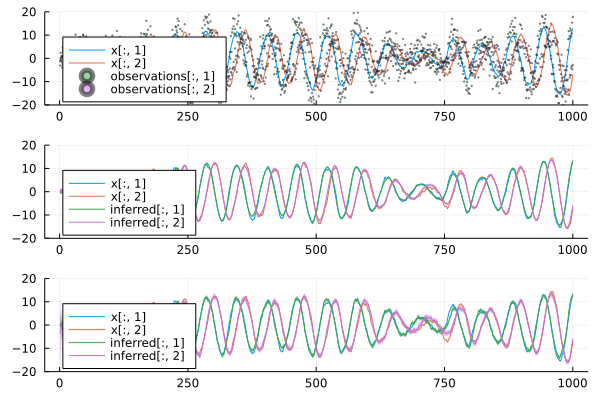

In [9]:
# Results verification

reshape_data(data) = transpose(reduce(hcat, data))

ylimit = (-20, 20)

generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit)

rmp_smoothing_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, 1:n, mean.(x_reactivemp_smoothing_inferred) |> reshape_data, ribbon = var.(x_reactivemp_smoothing_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_smoothing_results_plot = plot!(rmp_smoothing_results_plot, legend = :bottomleft, ylimit = ylimit)

rmp_filtering_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, 1:n, mean.(x_reactivemp_filtering_inferred) |> reshape_data, ribbon = var.(x_reactivemp_filtering_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
rmp_filtering_results_plot = plot!(rmp_filtering_results_plot, legend = :bottomleft, ylimit = ylimit)

plot(generated_data, rmp_smoothing_results_plot, rmp_filtering_results_plot, layout = @layout([ a; b; c ]))

In [10]:
benchmark_rmp_sizes = [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 25_000, 50_000 ];

In [11]:
reactivemp_benchmark_results = map(benchmark_rmp_sizes) do size
    # states, observations = generate_data(size, A, B, P, Q);
    
    benchmark_smoothing = @benchmark reactivemp_inference_smoothing(observations, $A, $B, $P, $Q) seconds=30 setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    benchmark_fitlering = @benchmark reactivemp_inference_filtering(observations, $A, $B, $P, $Q) seconds=30 setup=begin
        states, observations = generate_data($size, $A, $B, $P, $Q);
    end
    
    println("Finished $size")
    return (size, benchmark_smoothing, benchmark_fitlering)
end

Finished 50
Finished 100
Finished 250
Finished 500
Finished 1000
Finished 2000
Finished 5000
Finished 10000
Finished 15000
Finished 20000
Finished 25000
Finished 50000


12-element Vector{Tuple{Int64, BenchmarkTools.Trial, BenchmarkTools.Trial}}:
 (50, 3.507 ms, 417.572 μs)
 (100, 7.465 ms, 735.672 μs)
 (250, 20.885 ms, 1.660 ms)
 (500, 43.333 ms, 3.223 ms)
 (1000, 88.344 ms, 6.399 ms)
 (2000, 207.136 ms, 12.774 ms)
 (5000, 448.842 ms, 31.834 ms)
 (10000, 1.479 s, 67.735 ms)
 (15000, 1.447 s, 107.382 ms)
 (20000, 2.538 s, 148.534 ms)
 (25000, 3.840 s, 212.230 ms)
 (50000, 9.029 s, 448.036 ms)

In [12]:
benchmark_time_ms(trial) = minimum(trial).time / 1_000_000

benchmark_time_ms (generic function with 1 method)

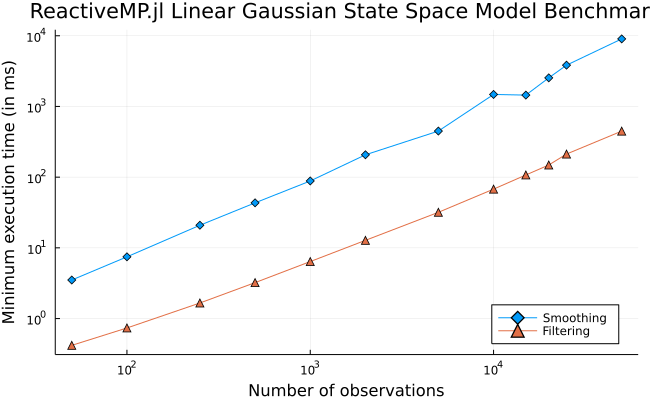

In [13]:
lgssm_scaling = plot(xscale = :log10, yscale = :log10, xlabel = "Number of observations", ylabel = "Minimum execution time (in ms)", title = "ReactiveMP.jl Linear Gaussian State Space Model Benchmark", legend = :bottomright, size = (650, 400))
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes)), markershape = :diamond, label = "Smoothing")
lgssm_scaling = plot!(lgssm_scaling, benchmark_rmp_sizes, map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes)), markershape = :utriangle, label = "Filtering")

display(lgssm_scaling)

# savefig(lgssm_scaling, "./plots/lgssm_scaling.svg")

In [14]:
import Turing, ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

true

In [15]:
Turing.@model LinearGaussianSSM(y, A, B, P, Q, ::Type{TV} = Vector{Vector{Float64}}) where TV = begin
    n = length(y)

    # State sequence.
    x = TV(undef, n)

    # Observe each point of the input.
    x[1] ~ MvNormal([ 0.0, 0.0 ], 1e1)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [16]:
function turing_inference_smoothing(observations, A, B, P, Q; nsamples = 500, method = Turing.HMC(0.1, 5))
    return Turing.sample(LinearGaussianSSM(observations, A, B, P, Q), method, nsamples)
end

turing_inference_smoothing (generic function with 1 method)

In [17]:
x_turing_500_smoothing_inferred  = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 500);
x_turing_1000_smoothing_inferred = turing_inference_smoothing(real_y, A, B, P, Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40


In [18]:
samples_500  = get(x_turing_500_smoothing_inferred, :x);
samples_1000 = get(x_turing_1000_smoothing_inferred, :x);

mx_500 = [ mean(samples_500.x[i].data) for i in 1:2n ]
vx_500 = [ std(samples_500.x[i].data)  for i in 1:2n ];

mx_1000 = [ mean(samples_1000.x[i].data) for i in 1:2n ]
vx_1000 = [ std(samples_1000.x[i].data)  for i in 1:2n ];

In [19]:
reshape_turing_data(data) = transpose(reshape(data, (2, Int(length(data) / 2))))

reshape_turing_data (generic function with 1 method)

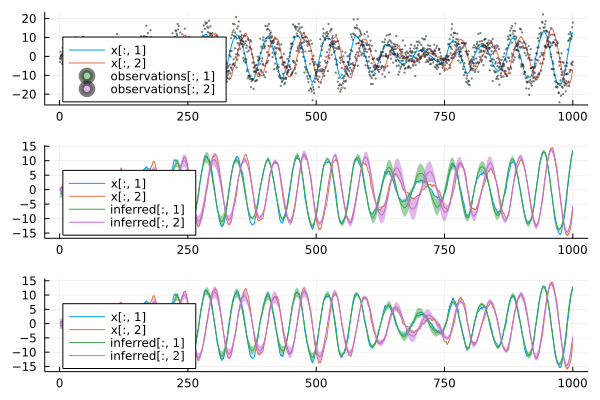

In [20]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 1, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft)

turing_500_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, 1:n, mx_500 |> reshape_turing_data, ribbon = vx_500 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_500_results_plot = plot!(turing_500_results_plot, legend = :bottomleft)

turing_1000_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, 1:n, mx_1000 |> reshape_turing_data, ribbon = vx_1000 |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
turing_1000_results_plot = plot!(turing_1000_results_plot, legend = :bottomleft)

plot(generated_data, turing_500_results_plot, turing_1000_results_plot, layout = @layout([ a; b; c ]))

In [21]:
reactivemp_filtering_n_100_benchmark = @benchmark reactivemp_inference_filtering($real_y, $A, $B, $P, $Q);
reactivemp_smoothing_n_100_benchmark = @benchmark reactivemp_inference_smoothing($real_y, $A, $B, $P, $Q);
turing_500_n_100_benchmark  = @benchmark turing_inference_smoothing($real_y, $A, $B, $P, $Q, nsamples = 500);
turing_1000_n_100_benchmark = @benchmark turing_inference_smoothing($real_y, $A, $B, $P, $Q, nsamples = 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


In [22]:
using ColorSchemes, Colors ;


c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.2) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ;

colors = [ c1, c2, c3, c4 ];

In [23]:
import CairoMakie

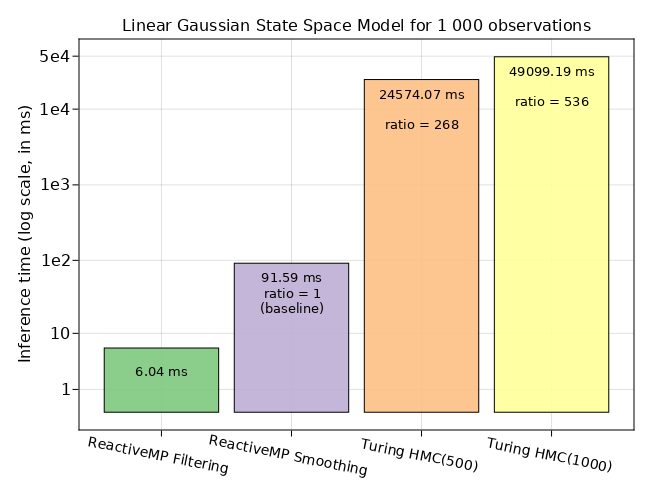

In [24]:
comparison_fig = begin
    
    # Local vars
    local bar_names  = [ "ReactiveMP Filtering", "ReactiveMP Smoothing", "Turing HMC(500)", "Turing HMC(1000)" ]
    local bar_values = [
        benchmark_time_ms(reactivemp_filtering_n_100_benchmark),
        benchmark_time_ms(reactivemp_smoothing_n_100_benchmark),
        benchmark_time_ms(turing_500_n_100_benchmark),
        benchmark_time_ms(turing_1000_n_100_benchmark)
    ] 
    
    local range = 1:length(bar_names)
    
    
    # Figure
    
    local fig = CairoMakie.Figure(resolution = (650, 500))

    # Axis
    
    local ax  = CairoMakie.Axis(fig)
    ax.ylabel = "Inference time (log scale, in ms)"
    ax.title  = "Linear Gaussian State Space Model for 1 000 observations"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = ([ 1, 10, 100, 1000, 10_000, 50_000 ], [ "1", "10", "1e2", "1e3", "1e4", "5e4" ])
    ax.xticklabelrotation = -π / 16
    ax.xticklabelalign = (0.5, 1.5)
    
    ax.xticks = (range, bar_names)
    ax.xticklabelsize = 14
    
    # Barplot 1
    
    local bp = CairoMakie.barplot!(ax, range, bar_values)
    
    bp.strokewidth = 1
    bp.color    = range
    bp.colormap = (:Accent_4, 0.9)
    bp.strokecolor = :black
    bp.x_gap = 0.12
    
    
    local text_values = map(bar_values) do value
        return string(round(value, digits = 2), " ms")
    end
    
    text_values[2] = string(text_values[2], "\n", string("ratio = ", Int(round(bar_values[2] / bar_values[2])), "\n(baseline)"))
    text_values[3] = string(text_values[3], "\n\n", string("ratio = ", Int(round(bar_values[3] / bar_values[2])), ""))
    text_values[4] = string(text_values[4], "\n\n", string("ratio = ", Int(round(bar_values[4] / bar_values[2])), ""))
    
    local tx = CairoMakie.text!(text_values, position = CairoMakie.Point.(range, bar_values .+ [ 1.55, 0.25, 0, 0 ]))
    
    tx.align  = (:center, :center)
    tx.offset = (0, -30)
    tx.color  = [ :black, :black, :black, :black ]
    tx.textsize = 13
    
    # Layout

    fig[1, 1] = ax
    
    # Return 
    
    CairoMakie.save("./plots/lgssm_comparison.svg", fig)
    CairoMakie.save("./plots/lgssm_comparison.png", fig)
    
    fig
end

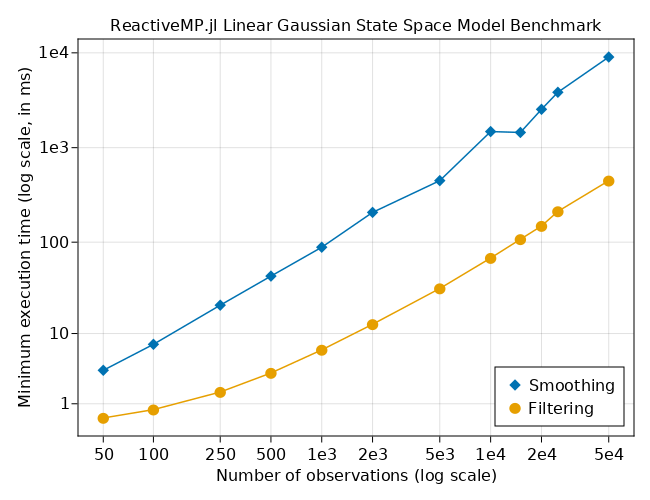

In [25]:
scaling_fig = begin 
    local fig = CairoMakie.Figure(resolution = (650, 500))
    
    local ax = CairoMakie.Axis(fig[1, 1])
    
    ax.title = "ReactiveMP.jl Linear Gaussian State Space Model Benchmark"
    
    ax.xlabel = "Number of observations (log scale)"
    ax.xscale = CairoMakie.Makie.pseudolog10
    ax.xticks = (
        [ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000 ], 
        [ "50", "100", "250", "500", "1e3", "2e3", "5e3", "1e4", "2e4", "5e4" ]
    )
    
    ax.ylabel = "Minimum execution time (log scale, in ms)"
    ax.yscale = CairoMakie.Makie.pseudolog10
    ax.yticks = (
        [ 1, 10, 100, 1_000, 10_000, 50_000 ], 
        [ "1", "10", "100", "1e3", "1e4", "5e4" ]
    )
    
    local range = benchmark_rmp_sizes
    local smoothing = map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][2]), 1:length(benchmark_rmp_sizes))
    local filtering = map(i -> benchmark_time_ms(reactivemp_benchmark_results[i][3]), 1:length(benchmark_rmp_sizes))
    
    CairoMakie.lines!(ax, range, smoothing)
    CairoMakie.scatter!(ax, range, smoothing, marker = :diamond, markersize = 15, label = "Smoothing")
    
    CairoMakie.lines!(ax, range, filtering)
    CairoMakie.scatter!(ax, range, filtering, marker = :circle, markersize = 15, label = "Filtering")
    
    CairoMakie.axislegend(position = :rb)
    
    CairoMakie.save("./plots/lgssm_scaling.svg", fig)
    CairoMakie.save("./plots/lgssm_scaling.png", fig)
    
    fig
end